In [1]:
%pylab inline
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


In [3]:
X_train.reshape(-1, 28*28).shape

(60000, 784)

(<matplotlib.image.AxesImage at 0x7f311a47ed10>, 5)

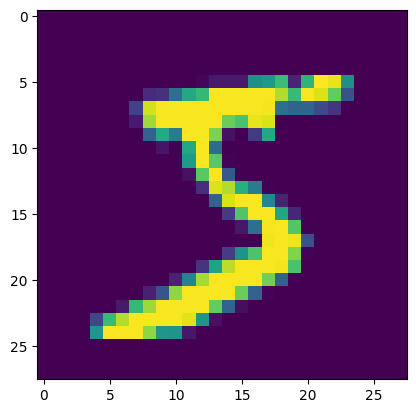

In [4]:
imshow(X_train[0]), Y_train[0]

In [28]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
class BobNet(torch.nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        self.sm = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x

loss 0.22 accuracy 0.95: 100%|██████████████| 1000/1000 [00:13<00:00, 75.58it/s]


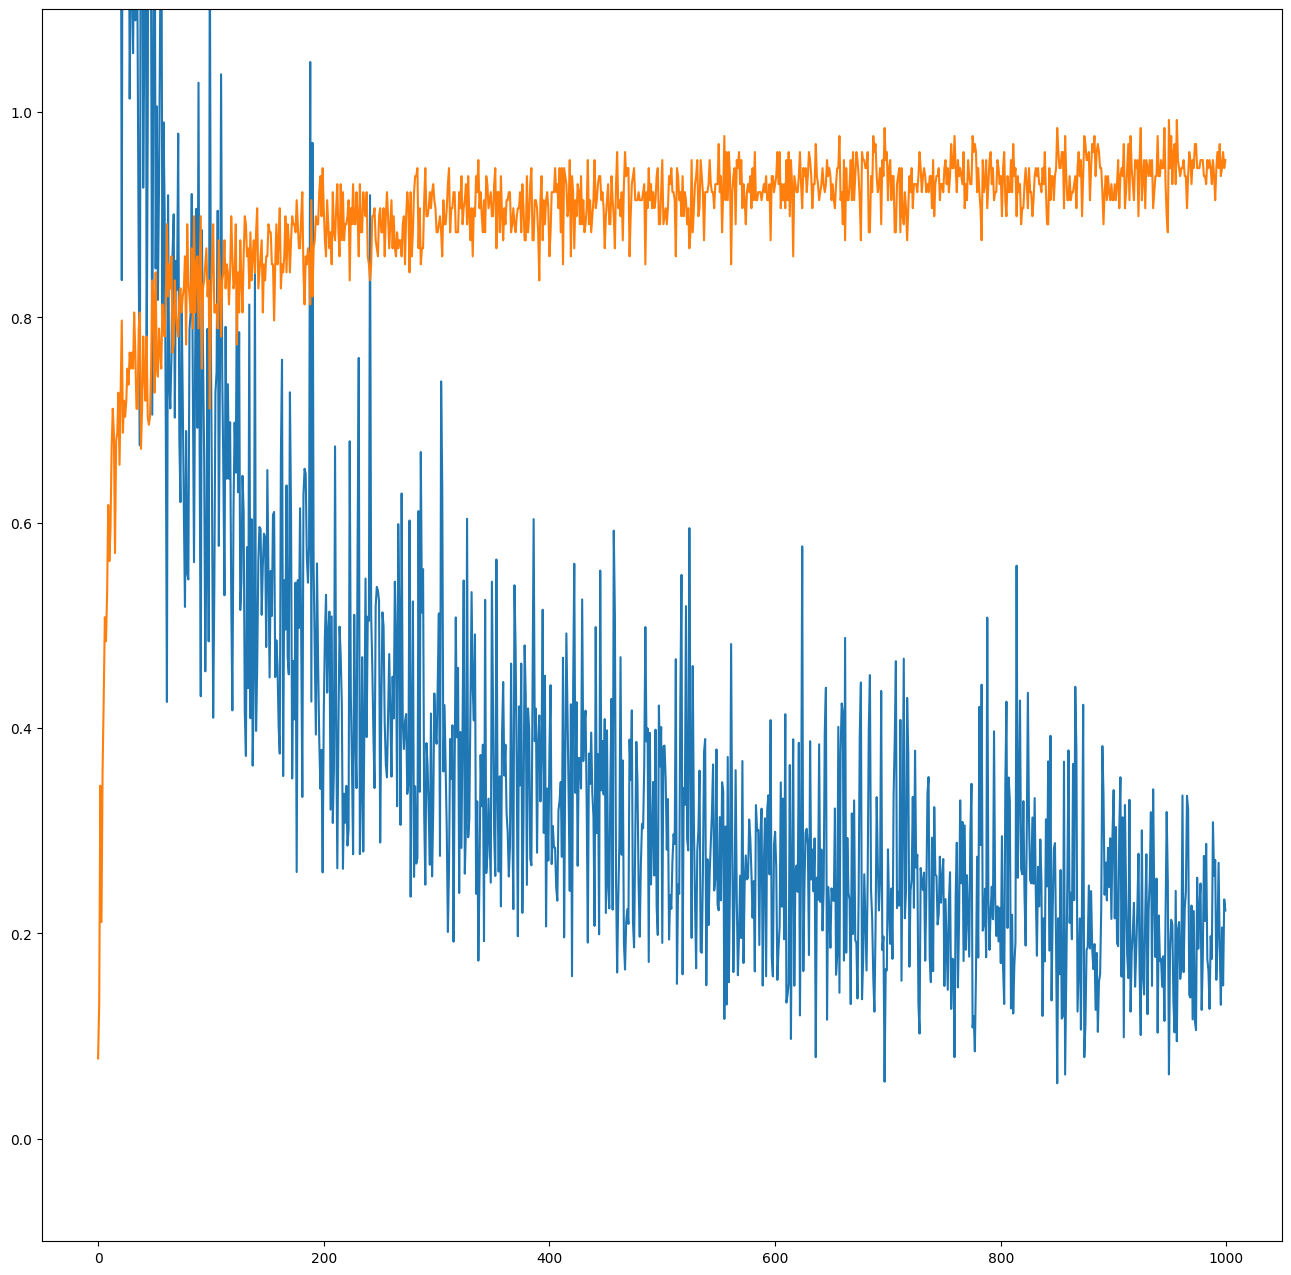

In [29]:
# training
model = BobNet()
BS = 128
losses, accuracies = [], []
loss_function = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
for i in (t:=trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    model.zero_grad()
    Y = torch.tensor(Y_train[samp]).long()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [30]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test_preds == Y_test).mean()

0.9321

tensor([7.2717e-06], grad_fn=<NllLossBackward0>)


tensor([[ 2.0330e-12,  3.6120e-15,  2.0159e-07,  7.1441e-07,  1.5802e-08,
          5.6423e-09,  1.4988e-12, -7.2718e-06,  2.9574e-11,  6.3108e-06]])

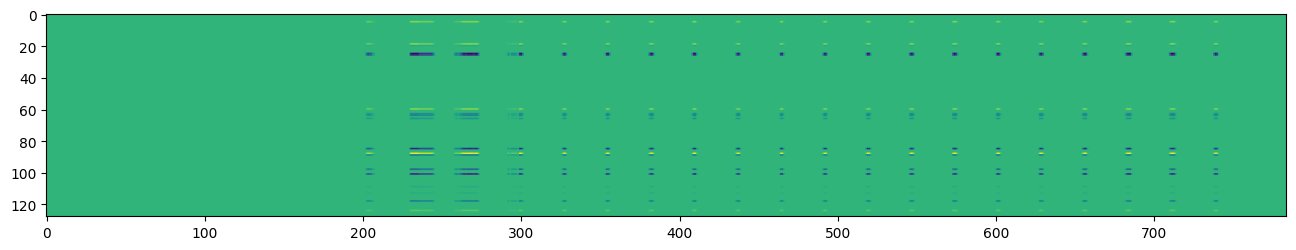

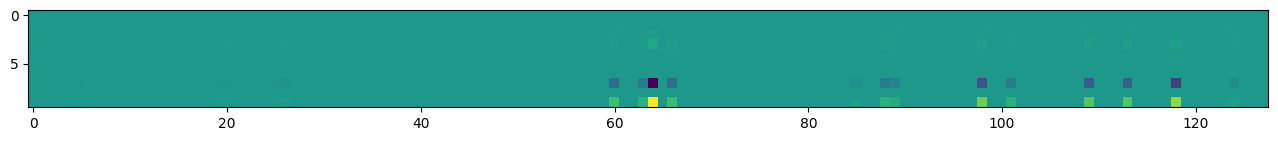

In [32]:
# Understanding gradients
model.zero_grad()
out = model(torch.tensor(X_test[0:1].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[0:1]).long())
print(loss)
loss.retain_grad()
loss.backward()
figsize(16, 16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

out.grad

In [8]:
# init the network
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
id(l1), id(l2)

(139846217757776, 139846217760656)

In [9]:
# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().T #transpose
l2[:] = model.l2.weight.detach().numpy().T #transpose

In [10]:
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test_preds == Y_test).mean()

0.9301

In [11]:
# training in numpy

ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

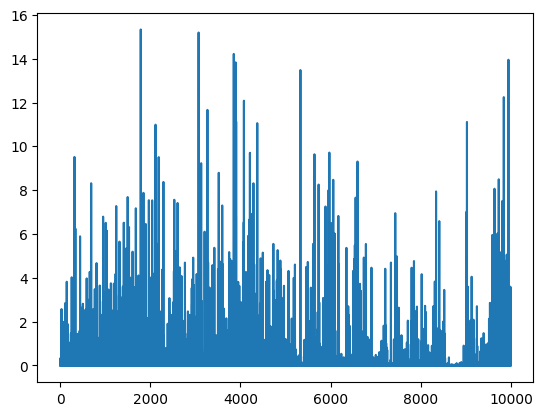

In [12]:
plot(ret)

(<matplotlib.image.AxesImage at 0x7f307c2cbd30>, 2)

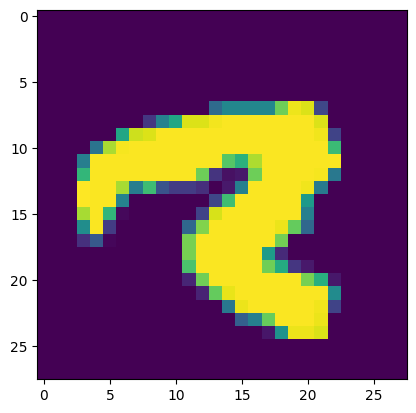

In [13]:
imshow(X_test[np.argmax(ret)]), Y_test[np.argmax(ret)]

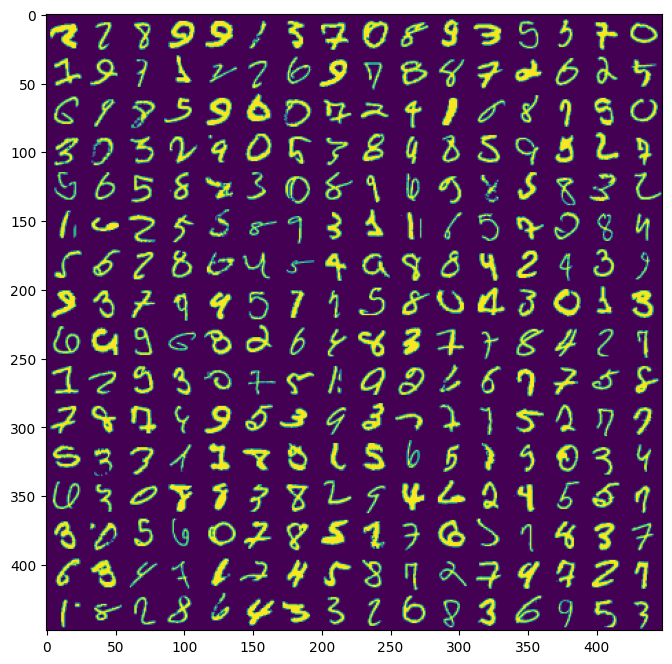

In [14]:
temp = 16

grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:temp*temp]
X_bad = X_test[[x[1] for x in grid]]
figsize(8, 8)
imshow(np.concatenate(X_bad.reshape((temp, 28*temp, 28)), axis=1))